In [2]:
import numpy as np
from pylab import plt
from __future__ import division,print_function#this notebook is python 2 2:-(
from functools import partial
import random
import numba as nb
import time

In [3]:
problem_and_sol_arr=np.array([[3,5,7,35],#my own example for debugging purposes
                              [4,11,13,143],#my own example for debugging purposes
                              [10,601, 911,547511],
                              [12,2081, 3329,6927649],
                              [14, 10007,15091,151015637],
                              [16, 40093,60013,2406101209],
                              [18, 150011,140007,36003690077],
                              [20, 700057,900001,630052000057],
                              [22, 2500339,3500227,8751754076953],
                              [24, 11600489, 14000083, 162407808840587],
                              [26, 41615281, 61616479, 2564187087815599],
                              [28, 150243361, 220293523, 33090127134000803],
                              [30, 800000087, 900000083, 720000144700007221]])
#first column: number of bits
#second, third column: prime factors.
#4th column: combined number to be factorized

Let's first calculate the number of iterations for two naive approaches.

* Approach one: we know there are 2 prime numbers in range 1..n, so we can calculate average time to find it.
Source for this appraoch: https://arxiv.org/abs/1102.1296v1
* Approach two: count from 1 to $n^{1/2}$ which certainly contains one prime factor, we could also randomly sample. Source of this approach: https://en.wikipedia.org/wiki/Trial_division.

(BTW, the test cases above are also from the arxiv paper)

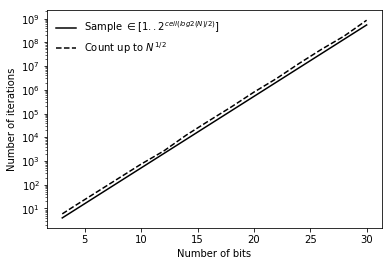

In [4]:
plt.figure(0)
plt.semilogy(problem_and_sol_arr[:,0],2**(problem_and_sol_arr[:,0])/2.,"k",label="Sample $\in[1..2^{ceil(log2(N)/2)}]$")
plt.semilogy(problem_and_sol_arr[:,0],problem_and_sol_arr[:,-1]**.5,"k--",label=r"Count up to $N^{1/2}$")
leg=plt.legend(loc=0)
leg.draw_frame(False)
plt.xlabel("Number of bits")
plt.ylabel("Number of iterations")
plt.show()

In [5]:
0b1010+0b01

11

In [6]:
test_integer=3
test_bits=np.unpackbits(np.array([test_integer],dtype=np.uint8)) #only up to uint8 :-(
print(test_integer,test_bits)
print(np.packbits(test_bits))

3 [0 0 0 0 0 0 1 1]
[3]


In [7]:
def unpackbits(x, num_bits):
  xshape = list(x.shape)
  x = x.reshape([-1, 1])
  to_and = 2**np.arange(num_bits).reshape([1, num_bits])
  return (x & to_and[::-1]).astype(bool).astype(int).reshape(xshape + [num_bits])
# tweaked version of https://stackoverflow.com/questions/18296035/how-to-extract-the-bits-of-larger-numeric-numpy-data-types

In [8]:
def packbits(x, num_bits):
  xshape = list(x.shape)
  x = x.reshape([-1, num_bits])
  if len(xshape)==1:
    xshape = list(x.shape)
  to_and = 2**np.arange(num_bits).reshape([1, num_bits])
  return np.sum(x * to_and[::-1],axis=(len(xshape)-1)).astype(int).reshape(xshape[:-1])

In [9]:
packbits(unpackbits(np.array([9]),4),4)

array([9])

In [10]:
for nn,(n,p,q,N) in enumerate(problem_and_sol_arr[:]):
    bits_p,bits_q=unpackbits(np.array([p,q]),num_bits=n) # assumption in the examples is that they have equal number of bits
    bits_N=unpackbits(np.array([N]),num_bits=2*n)
    print("N:",bits_N,N,bin(N),len(bin(N))-2)
    print("p:",bits_p,p,bin(p),len(bin(p))-2)
    print("q:",bits_q,q,bin(q),len(bin(q))-2)

N: [[1 1 0 0 0 1]] 35 0b100011 6
p: [1 0 1] 5 0b101 3
q: [1 1 1] 7 0b111 3
N: [[1 1 1 1 0 0 0 1]] 143 0b10001111 8
p: [1 1 0 1] 11 0b1011 4
q: [1 0 1 1] 13 0b1101 4
N: [[1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1]] 547511 0b10000101101010110111 20
p: [1 0 0 1 1 0 1 0 0 1] 601 0b1001011001 10
q: [1 1 1 1 0 0 0 1 1 1] 911 0b1110001111 10
N: [[1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0]] 6927649 0b11010011011010100100001 23
p: [1 0 0 0 0 1 0 0 0 0 0 1] 2081 0b100000100001 12
q: [1 0 0 0 0 0 0 0 1 0 1 1] 3329 0b110100000001 12
N: [[1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1]] 151015637 0b1001000000000101000011010101 28
p: [1 1 1 0 1 0 0 0 1 1 1 0 0 1] 10007 0b10011100010111 14
q: [1 1 0 0 1 1 1 1 0 1 0 1 1 1] 15091 0b11101011110011 14
N: [[1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1]] 2406101209 0b10001111011010100011000011011001 32
p: [1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1] 40093 0b1001110010011101 16
q: [1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1] 60013 0b11101010011011

In [11]:
@nb.jit(nopython=True)
def E_fun_mod_N(x,N):
    return abs(N%x)

@nb.jit(nopython=True)
def E_fun(x,N,E_fun_type):
    if E_fun_type==0:
        return E_fun_mod_N(x,N)
    else:
        raise Exception("Function type for E_fun not yet implemented")
        return 0


In [44]:
@nb.jit(nopython=True)
def perform_prime_factorization(problem_and_sol_arr,num_runs = 1000, max_iter = None,
                                N_case_i=0, #problem_and_sol_arr.shape[0]
                                N_cases=4,
                                E_fun_type=0):

    data_arr=np.zeros((problem_and_sol_arr.shape[0],6))

    cnt_failed_calc=0
    cnt_failed_calc_per_N=0

    for nn in np.arange(N_case_i,N_case_i+N_cases,1): # https://github.com/numba/numba/issues/4508
        (n,p,q,N)=problem_and_sol_arr[nn,:] # can't use enumerate, would crash in numba
        print("Number of bits n=",n)
        max_iter=max(3*2**(3.*n),5000)
        cnt=0
        cnt_failed_calc_per_N=0

        #E_fun=partial(E_fun_template,N=N)

        #T = 0.1 * 2**(2*n) #based on paper
        T = 0.1 * 2**(n) #TODO adapt this to E_fun!; currently it's not optimal + save acceptance ratios.
        beta = 1/T

        cnt_iter_arr=np.zeros((num_runs,))

        for rr in range(num_runs): # do a 1000 different runs per algos, it's stochastic so we need statistics
            #print("Simulation {}/{} for number of bits n={}".format(rr,num_runs,n))
            # p_new = packbits(np.random.randint(2, size=n, n)
            # p_new = packbits(np.random.randint(2, size=(n-1)),(n-1))*2+1 #only odd numbers >1 can be wanted prime; so this line doesn't work
            p_new = 2*np.random.randint(2**(n-1)-1)+3
            E_new = E_fun(p_new,N=N,E_fun_type=E_fun_type)
            cnt_iter = 0
            while (cnt_iter<max_iter) and (E_new>0): # keep on guessing using monte carlo algorithm
                #save data
                p_old=p_new
                E_old=E_new

                #TODO remove while loop, get better solution if p_new=1
                while (p_new==p_old): # avoid getting p_new = 1, as this gives wrong result
                    #propose flip
                    bit_pos=np.random.randint(n-1) # only odd numbers >1 can be wanted prime, don't pick bit 0
                    #speedup proposal: https://eli.thegreenplace.net/2018/slow-and-fast-methods-for-generating-random-integers-in-python/
                    p_new=p_old ^ 2**(bit_pos+1) # flip bit using XOR
                    if p_new==1:
                        p_new=p_old
                # p_new=(p_old-2) ^ 2**(bit_pos+1)+2 # flip bit using XOR
                E_new=E_fun(p_new,N=N,E_fun_type=E_fun_type)
                D_E=E_new-E_old
                #check whether we accept flip
                u=random.random()
                p_flip=min(1,np.exp(-beta*D_E))

                #else:
                if (p_flip>u):#accept flips
                    pass
                else:#reset
                    p_new=p_old
                    E_new=E_old

                cnt_iter+=1


            if cnt_iter==max_iter:
                #print("Reached maximum number of iterations for n: ",n," N: ",N)
                cnt_failed_calc+=1
                cnt_failed_calc_per_N+=1
            cnt_iter_arr[rr]=(cnt_iter+1) # initial condition = also counted as iteration.

        print("Percentage failed calculations: ",cnt_failed_calc_per_N/num_runs*100,"%")
        data_arr[nn,0]=n    
        data_arr[nn,1]=np.mean(cnt_iter_arr)
        data_arr[nn,2]=np.std(cnt_iter_arr)
        data_arr[nn,3]=np.min(cnt_iter_arr)
        data_arr[nn,4]=np.max(cnt_iter_arr)
        data_arr[nn,5]=np.median(cnt_iter_arr)

    print("Failed calculations: ",cnt_failed_calc)
    return data_arr


In [45]:
# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
data_arr=perform_prime_factorization(problem_and_sol_arr,num_runs = 1000, max_iter = None,N_cases=2, #problem_and_sol_arr.shape[0]
                                    E_fun_type=0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
data_arr=perform_prime_factorization(problem_and_sol_arr,num_runs = 1000, max_iter = None,N_cases=2, #problem_and_sol_arr.shape[0]
                                    E_fun_type=0)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Number of bits n= 3
Percentage failed calculations:  0.0 %
Number of bits n= 4
Percentage failed calculations:  0.0 %
Failed calculations:  0
Elapsed (with compilation) = 0.953000068665
Number of bits n= 3
Percentage failed calculations:  0.0 %
Number of bits n= 4
Percentage failed calculations:  0.0 %
Failed calculations:  0
Elapsed (after compilation) = 0.00300002098083


When executing this line of code without jil: (version on 4/29/2020)
start = time.time()
data_arr=perform_prime_factorization(problem_and_sol_arr,num_runs = 1000,
                                     max_iter = None,N_cases=8, #problem_and_sol_arr.shape[0]
                                    E_fun_type=0)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

I get as output:
Number of bits n= 3
Percentage failed calculations:  0.0 %
Number of bits n= 4
Percentage failed calculations:  0.0 %
Number of bits n= 10
Percentage failed calculations:  0.0 %
Number of bits n= 12
Percentage failed calculations:  0.0 %
Number of bits n= 14
Percentage failed calculations:  0.0 %
Number of bits n= 16
Percentage failed calculations:  0.0 %
Number of bits n= 18
Percentage failed calculations:  0.0 %
Number of bits n= 20
Percentage failed calculations:  0.0 %
Failed calculations:  0
Elapsed (after compilation) = 4741.00999999


When doing it with jil, I get:
Number of bits n= 3
Percentage failed calculations:  0.0 %
Number of bits n= 4
Percentage failed calculations:  0.0 %
Number of bits n= 10
Percentage failed calculations:  0.0 %
Number of bits n= 12
Percentage failed calculations:  0.0 %
Number of bits n= 14
Percentage failed calculations:  0.0 %
Number of bits n= 16
Percentage failed calculations:  0.0 %
Number of bits n= 18
Percentage failed calculations:  0.0 %
Number of bits n= 20
Percentage failed calculations:  0.0 %
Failed calculations:  0
Elapsed (after compilation) = 50.3919999599

Original function was:

@nb.jit(nopython=True)
def E_fun_mod_N(x,N):
    return abs(N%x)

@nb.jit(nopython=True)
def E_fun(x,N,E_fun_type):
    if E_fun_type==0:
        return E_fun_mod_N(x,N)
    else:
        raise Exception("Function type for E_fun not yet implemented")
        return 0

#in python 3 I could use wrapped for this test without jit:
    https://stackoverflow.com/questions/1166118/how-to-strip-decorators-from-a-function-in-python
    
>>> @somedecorator
>>> def add(x, y):
...     return x + y
...
>>> orig_add = add.__wrapped__
>>> orig_add(3, 4)

>>> from undecorated import undecorated
>>> undecorated(spam) # this is also an option!

#with our without jil: 
@nb.jit(nopython=True)
def perform_prime_factorization(problem_and_sol_arr,num_runs = 1000, max_iter = None,
                                N_cases=4, #problem_and_sol_arr.shape[0]
                                E_fun_type=0):

    data_arr=np.zeros((problem_and_sol_arr.shape[0],6))

    cnt_failed_calc=0
    cnt_failed_calc_per_N=0

    for nn in range(N_cases): # https://github.com/numba/numba/issues/4508
        (n,p,q,N)=problem_and_sol_arr[nn,:] # can't use enumerate, would crash in numba
        print("Number of bits n=",n)
        max_iter=max(3*2**(3*n),5000)
        cnt=0
        cnt_failed_calc_per_N=0

        #E_fun=partial(E_fun_template,N=N)

        #T = 0.1 * 2**(2*n) #based on paper
        T = 0.1 * 2**(n) #TODO adapt this to E_fun!; currently it's not optimal + save acceptance ratios.
        beta = 1/T

        cnt_iter_arr=np.zeros((num_runs,))

        for rr in range(num_runs): # do a 1000 different runs per algos, it's stochastic so we need statistics

            p_new = 2*np.random.randint(2**(n-1)-1)+3
            E_new = E_fun(p_new,N=N,E_fun_type=E_fun_type)
            cnt_iter = 0
            while (cnt_iter<max_iter) and (E_new>0): # keep on guessing using monte carlo algorithm
                #save data
                p_old=p_new
                E_old=E_new

                #TODO remove while loop, get better solution if p_new=1
                while (p_new==p_old): # avoid getting p_new = 1, as this gives wrong result
                    #propose flip
                    bit_pos=np.random.randint(n-1) # only odd numbers >1 can be wanted prime, don't pick bit 0
                    #speedup proposal: https://eli.thegreenplace.net/2018/slow-and-fast-methods-for-generating-random-integers-in-python/
                    p_new=p_old ^ 2**(bit_pos+1) # flip bit using XOR
                    if p_new==1:
                        p_new=p_old
                # p_new=(p_old-2) ^ 2**(bit_pos+1)+2 # flip bit using XOR
                E_new=E_fun(p_new,N=N,E_fun_type=E_fun_type)
                D_E=E_new-E_old
                #check whether we accept flip
                u=random.random()
                p_flip=min(1,np.exp(-beta*D_E))

                #else:
                if (p_flip>u):#accept flips
                    pass
                else:#reset
                    p_new=p_old
                    E_new=E_old

                cnt_iter+=1


            if cnt_iter==max_iter:
                print("Reached maximum number of iterations for n: ",n," N: ",N)
                cnt_failed_calc+=1
                cnt_failed_calc_per_N+=1
            cnt_iter_arr[rr]=(cnt_iter+1) # initial condition = also counted as iteration.

        print("Percentage failed calculations: ",cnt_failed_calc/num_runs*100,"%")
        data_arr[nn,0]=n    
        data_arr[nn,1]=np.mean(cnt_iter_arr)
        data_arr[nn,2]=np.std(cnt_iter_arr)
        data_arr[nn,3]=np.min(cnt_iter_arr)
        data_arr[nn,4]=np.max(cnt_iter_arr)
        data_arr[nn,5]=np.median(cnt_iter_arr)

    print("Failed calculations: ",cnt_failed_calc)
    return data_arr


In [46]:
# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
data_arr=perform_prime_factorization(problem_and_sol_arr,num_runs = 1000,
                                     max_iter = None,N_cases=9, #problem_and_sol_arr.shape[0]
                                    E_fun_type=0)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

#up to n bits = 22: Failed calculations:  0; Elapsed (after compilation) = 470.773000002

Number of bits n= 3
Percentage failed calculations:  0.0 %
Number of bits n= 4
Percentage failed calculations:  0.0 %
Number of bits n= 10
Percentage failed calculations:  0.0 %
Number of bits n= 12
Percentage failed calculations:  0.0 %
Number of bits n= 14
Percentage failed calculations:  0.0 %
Number of bits n= 16
Percentage failed calculations:  0.0 %
Number of bits n= 18
Percentage failed calculations:  0.0 %
Number of bits n= 20
Percentage failed calculations:  0.0 %
Number of bits n= 22
Percentage failed calculations:  0.0 %
Failed calculations:  0
Elapsed (after compilation) = 470.773000002


In [47]:
#KNOWN ISSUE, BUT TRICKY: for numpy power overflow is known: https://github.com/numpy/numpy/issues/10964
# in our case n is a value from data_arr, so we have the overflow issue.

#look at results to debug code! and compare with current threshold mechanism for max iteration -> clearly I found the culprit :-(
for iii,jjj,n in zip(data_arr[:,0],data_arr[:,1],problem_and_sol_arr[:,0]):
    #print(iii,jjj,":",max(3*2**(4*n),5000),max(3*2**(3*n),5000),";",3*2**(4*n),3*2**(3*n))
    print(iii,jjj,":",max(3*2**(4*n),5000),max(3*2**(3*n),5000),";",3*2**(4*n),3*2**(3*n),";",3*2**(4.*n))#making it a float works! 
    
print(np.log2(50))


    
#In my simulations up to now (5/6/2020) I was using max(3*2**(4*n),5000) and from n=22 things started failing, I now see why,
#it's overflowing.

3.0 1.332 : 12288 5000 ; 12288 1536 ; 12288.0
4.0 3.139 : 196608 12288 ; 196608 12288 ; 196608.0
10.0 797.743 : 3298534883328 3221225472 ; 3298534883328 3221225472 ; 3.29853488333e+12
12.0 1745.572 : 844424930131968 206158430208 ; 844424930131968 206158430208 ; 8.44424930132e+14
14.0 6592.923 : 216172782113783808 13194139533312 ; 216172782113783808 13194139533312 ; 2.16172782114e+17
16.0 43122.485 : 5000 844424930131968 ; 0 844424930131968 ; 5.53402322211e+19
18.0 81356.754 : 5000 54043195528445952 ; 0 54043195528445952 ; 1.41670994486e+22
20.0 929406.722 : 5000 3458764513820540928 ; 0 3458764513820540928 ; 3.62677745884e+24
22.0 3444549.627 : 5000 5000 ; 0 0 ; 9.28455029464e+26
0.0 0.0 : 5000 5000 ; 0 0 ; 2.37684487543e+29
0.0 0.0 : 5000 5000 ; 0 0 ; 6.0847228811e+31
0.0 0.0 : 5000 5000 ; 0 0 ; 1.55768905756e+34
0.0 0.0 : 5000 5000 ; 0 0 ; 3.98768398735e+36
5.64385618977


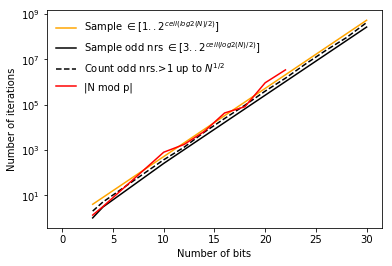

In [48]:
#TODO: errorbars in this loglog plot, code can be found here: https://matplotlib.org/2.0.2/examples/pylab_examples/log_demo.html.

plt.figure(0)
plt.semilogy(problem_and_sol_arr[:,0],2**(problem_and_sol_arr[:,0])/2.,"orange",label="Sample $\in[1..2^{ceil(log2(N)/2)}]$")
# ..-1 because 1 is not our prime number
plt.semilogy(problem_and_sol_arr[:,0],(2**(problem_and_sol_arr[:,0])/2.+1)//2-1,"k",label="Sample odd nrs $\in[3..2^{ceil(log2(N)/2)}]$")
#plt.semilogy(problem_and_sol_arr[:,0],problem_and_sol_arr[:,-1]**.5,"k--",label=r"Count up to $N^{1/2}$")
plt.semilogy(problem_and_sol_arr[:,0],np.floor(problem_and_sol_arr[:,-1]**.5+1)//2-1,"k--",label=r"Count odd nrs.>1 up to $N^{1/2}$")
plt.semilogy(data_arr[:,0],data_arr[:,1],"r",label=r"|N mod p|")
leg=plt.legend(loc=0)
leg.draw_frame(False)
plt.xlabel("Number of bits")
plt.ylabel("Number of iterations")
#TODO: plot errorbars.
plt.show()


In [ ]:
data_arr[0,1]

In [ ]:
# count all odd numbers, excluding 1 up to sqrt(N)
print((15**.5),np.floor(15**.5+1)//2-1) # check counting of odd numbers up to square of to be decomposed number
print((35**.5),np.floor(35**.5+1)//2-1)

# for this test case we know that both p and q have same number of bits, so only count those odd numbers.
# does not work for this one: print((15**.5),np.floor(15**.5+1)//2-1) # check counting of odd numbers up to square of to be decomposed number
n = 3
# n-2 because first and last bit fixed; + there are two numbers in that range!
print(2**(n-2)//2)

# do as if we don't know both numbers have same number of bits; but sample two odd numbers, excluding 1
print(2**(n-1)//2-1)

In [ ]:
print(np.log2(15),np.log2(35))
print(np.log2(3),np.log2(5),np.log2(7))

In [ ]:
15%1


In [ ]:
n=4
print("method 1")
# this still gives 1 as initial condition:
for ii in range(20):
    p_new = packbits(np.random.randint(2, size=(n-1)),(n-1))*2+1
    print(p_new)
print("method 2")   
# this doesn't give one as itnitial condition
for ii in range(40):   
    p_new = 2*np.random.randint(2**(n-1)-1)+3
    print(p_new)


In [ ]:
np.random.randint(2**(n-1))


In [ ]:
data_arr[:,0]

TODO:
    Do sweeps of noise for every integer size - optimize it to get better scaling
        Spin index dependent noise?
    Implement other Energies and test scaling
    Implement (p,q spin set)
    Make acceptance ratio plots.